<a href="https://colab.research.google.com/github/aadityakhant/fakeNewsDetection/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read each line and generate datapoint

In [ ]:
import re #regexp
import sys
import random
import csv
import numpy as np
import pickle
import keras as k
from matplotlib import pyplot as plt
csv.field_size_limit(999999999)

import warnings
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [ ]:
Type = {"fake": "fake", "rumor":"fake", "satire":"fake", "conspiracy":"fake", "junksci":"fake", "hate":"fake", "unreliable":"fake", "clickbait":"clickbait", "political":"valid", "reliable":"valid",  "bias":"bias"}

Count = {"fake": 15000, "rumor":5000, "satire":5000, "conspiracy":5000, "junksci":5000, "hate":5000, "unreliable":10000, "clickbait":50000, "political":25000, "reliable":25000, "bias":50000}


1. Download FakeNewsCorpus data from https://github.com/several27/FakeNewsCorpus?tab=readme-ov-file
2. Dowanload all files and then unzip any one file.
3. Download Glove embeddings from https://www.kaggle.com/datasets/watts2/glove6b50dtxt

In [ ]:
count = 0
with open('./out.csv', 'w', newline='') as out:
    with open('./news.csv/news_cleaned_2018_02_13.csv', encoding='utf8') as file:
        reader = csv.reader(file)
        writer = csv.writer(out)
        for r in reader:
            if(count == 200000):
                break
            if len(r) == 17:
                #title->9, content->5, type->3
                title = r[9]
                content = r[5]
                classification = r[3]
                #remove urls
                title = re.sub(r"http\S+",'', title)
                content = re.sub(r"http\S+",'', content)
                #remove non-alfa-numeric and stopwords.
                title = [word.lower() for word in tokenizer.tokenize(title) if word.isalpha() and not word.lower() in stop_words]
                content = [word.lower() for word in tokenizer.tokenize(content) if word.isalpha() and not word.lower() in stop_words]
                #change classification and write
                if len(title) != 0 and len(content) != 0:
                    if classification in Type.keys():
                        if Count[classification]:
                            try:
                                writer.writerow([ " ".join(title),  " ".join(content), Type[classification]])
                                Count[classification] -= 1
                                print(count)
                                count += 1
                            except:
                                pass

Read processed data and generate embeddings

In [ ]:
#0 -> title; 1 -> content; 2 -> type
title_length = {}
content_length = {}
data = []
with open('./out.csv') as file:
        reader = csv.reader(file)
        for r in reader:
                data.append(r)
                if len(r[0].split()) in title_length.keys():
                        title_length[len(r[0].split())] += 1
                else:
                        title_length[len(r[0].split())] = 1
                if len(r[1].split()) in content_length.keys():
                        content_length[len(r[1].split())] += 1
                else:
                        content_length[len(r[1].split())] = 1
random.shuffle()

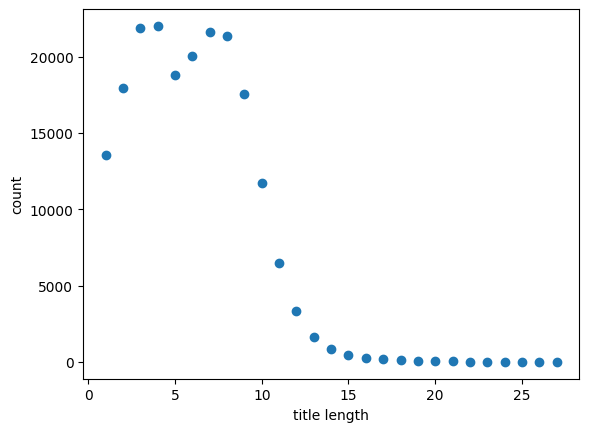

In [ ]:
import matplotlib.pylab as plt
plt.scatter(title_length.keys(), title_length.values())
plt.xlabel('title length')
plt.ylabel('count')
plt.show()

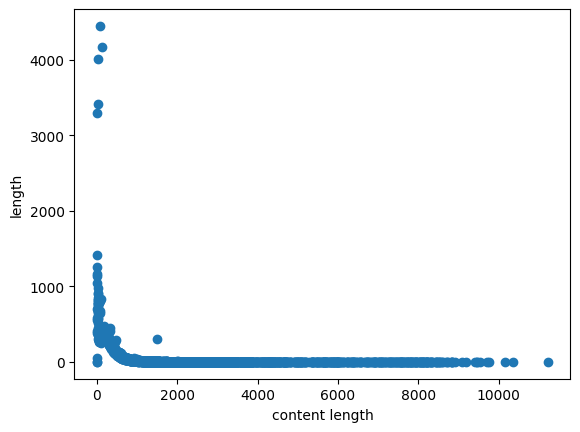

In [ ]:
plt.scatter(content_length.keys(), content_length.values())
plt.xlabel('content length')
plt.ylabel('length')
plt.show()

In [ ]:
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [ ]:
#create empty folder with name data in current directory
one_hot_encoding = np.eye(4)
classes = {'fake':0, 'clickbait':1, 'valid':2, 'bias':3}
dbfile = open('examplePickle', 'wb')
words = embeddings_dict.keys()
for i in range(100):
    dbfile = open('./data/pickle-' + str(i), 'wb')
    for j in range(2000):
        #title
        title = data[2000*i + j][0].split()
        if len(title)<=15:
            title = [embeddings_dict[t] if t in words else np.zeros(50) for t in title]
            title = np.pad(title, ((0,15-len(title)),(0,0)))
        else:
            title = [embeddings_dict[t] if t in words else np.zeros(50) for t in title[:15]]
        #content
        content = data[2000*i + j][0].split()
        if len(content)<=1600:
            content = [embeddings_dict[t] if t in words else np.zeros(50) for t in content]
            content = np.pad(content, ((0,1600-len(content)),(0,0)))
        else:
            content = [embeddings_dict[t] if t in words else np.zeros(50) for t in content[:1600]]
        #one hot encode type
        classification = one_hot_encoding[classes[data[2000*i + j][2]]]
        #append to dataset
        pickle.dump([title,content,classification], dbfile)
dbfile.close()